# GOAL PREDICTION ALGORITHM

### Import Libraries and Dataset

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit 
import pickle

In [5]:
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from statsmodels.api import OLS, add_constant
from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import *
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [189]:
df = pd.read_csv("PL Teams 2022--23 Dataset.csv")

### Data Inspection

In [192]:
df.describe()

,table_position,matchday,total_shots,shots_on_target,goals,possesion,duels_won
count,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000
mean,10.500000,19.500000,10.338158,4.182895,1.443421,0.499697,0.500842
std,5.770079,10.973078,5.064289,2.195809,1.336410,0.127814,0.050443
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.180000,0.350000
25%,5.750000,10.000000,7.000000,3.000000,0.000000,0.400000,0.470000
50%,10.500000,19.500000,10.000000,4.000000,1.000000,0.500000,0.500000
75%,15.250000,29.000000,13.000000,5.000000,2.000000,0.590000,0.530000
max,20.000000,38.000000,31.000000,12.000000,9.000000,0.820000,0.650000


In [194]:
def inspection(df):
    print(f'Data Shape=: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['Data Types'])
    summ['Missing Values'] = df.isna().sum()
    summ['Missing Percentage'] = (df.isna().sum())/len(df)*100
    summ['Duplicates'] = df.duplicated().sum()
    summ['Unique'] = df.nunique().values
    summ['Count'] = df.count().values

    display(summ)
    
inspection(df)

Data Shape=: (760, 8)


,Data Types,Missing Values,Missing Percentage,Duplicates,Unique,Count
table_position,int64,0,0.0,0,20,760
team_name,object,0,0.0,0,20,760
matchday,int64,0,0.0,0,38,760
total_shots,int64,0,0.0,0,31,760
shots_on_target,int64,0,0.0,0,13,760
goals,int64,0,0.0,0,9,760
possesion,float64,0,0.0,0,61,760
duels_won,float64,0,0.0,0,31,760


From this output, we know that there are no missing or duplicated values in any columns. The dataset is properly formatted and ready for analysis.

### Correlation Heatmap

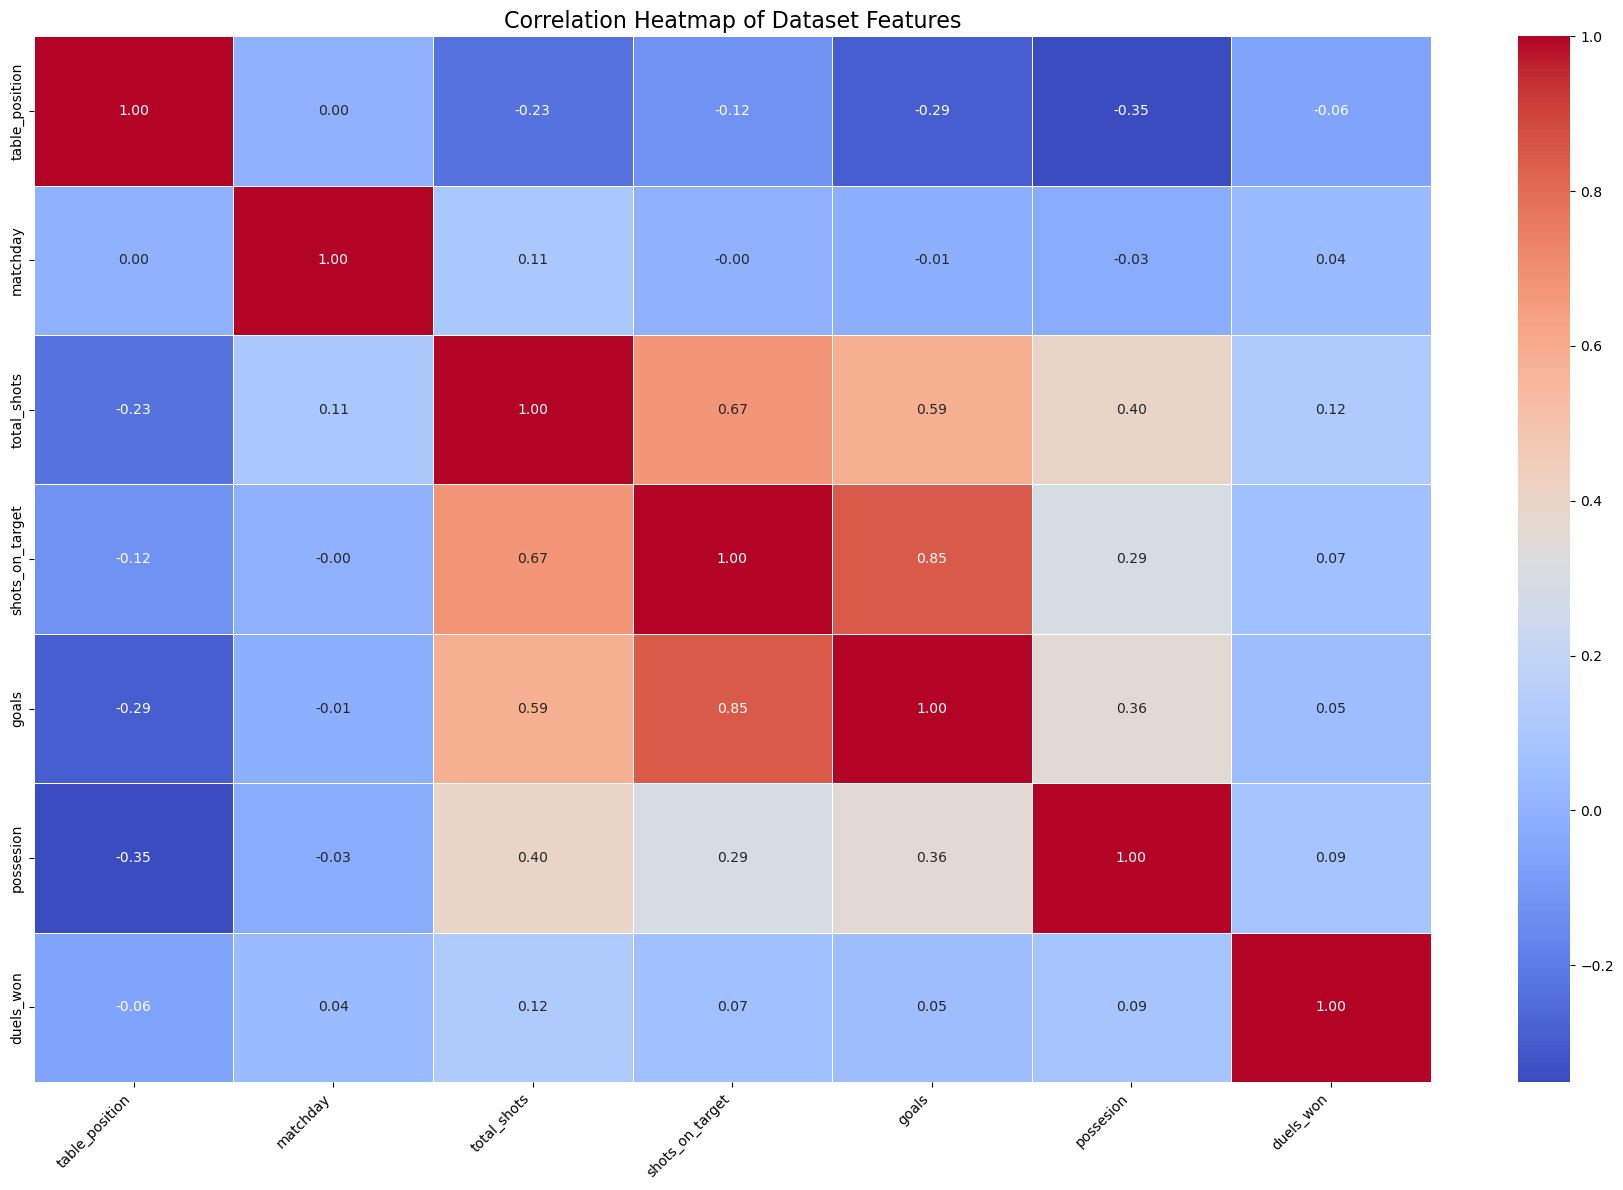

In [61]:
numeric_data = df.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
correlation_matrix = numeric_data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(18, 12))

# Draw the heatmap
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt='.2f', linewidths=0.5)

# Title and labels
plt.title('Correlation Heatmap of Dataset Features', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

Our target variable is "goals". From the heatmap, we can observe that the feature with the highest correlation is "shots on target". 

In [64]:
# Group by 'team' and sum the goals
team_goals = df.groupby('team_name')['goals'].sum().sort_values(ascending=False)

# Print the result
print(team_goals)

team_name
Manchester City            95
Arsenal                    88
Liverpool                  75
Brighton & Hove Albion     72
Tottenham Hotspur          70
Newcastle United           68
Brentford                  58
Manchester United          58
Fulham                     55
Aston Villa                51
Leicester                  51
Leeds United               48
West Ham United            42
Crystal Palace             40
Chelsea                    38
Nottingham Forest          38
Bournemouth                37
Southampton                36
Everton                    34
Wolverhampton Wanderers    31
Name: goals, dtype: int64


In [156]:
# Group by 'team' and sum the shots on target
team_shots = df.groupby('team_name')['shots_on_target'].sum().sort_values(ascending=False)

# Print the result
print(team_shots)

team_name
Arsenal                    212
Brighton & Hove Albion     193
Tottenham Hotspur          183
Newcastle United           173
Manchester United          170
Leicester                  169
Brentford                  159
Liverpool                  158
Fulham                     156
Leeds United               155
Chelsea                    155
Manchester City            154
Everton                    153
Nottingham Forest          147
Bournemouth                147
West Ham United            147
Wolverhampton Wanderers    143
Aston Villa                136
Crystal Palace             135
Southampton                134
Name: shots_on_target, dtype: int64


In [158]:
# Group by team and calculate total shots and total goals
team_stats = df.groupby('team_name').agg({'shots_on_target': 'sum', 'goals': 'sum'})

# Compute shots per goal (avoid division by zero)
team_stats['shots_per_goal'] = team_stats['shots_on_target'] / team_stats['goals']
team_stats['shots_per_goal'].replace([np.inf, np.nan], 0, inplace=True)  # Handle division by zero

# Sort in ascending order (lower shots per goal is better)
team_stats = team_stats.sort_values(by='shots_per_goal', ascending=True)

# Print result
print(team_stats)

                         shots_on_target  goals  shots_per_goal
team_name                                                      
Manchester City                      154     95        1.621053
Liverpool                            158     75        2.106667
Arsenal                              212     95        2.231579
Newcastle United                     173     70        2.471429
Tottenham Hotspur                    183     70        2.614286
Aston Villa                          136     51        2.666667
Brighton & Hove Albion               193     72        2.680556
Brentford                            159     58        2.741379
Fulham                               156     55        2.836364
Manchester United                    170     58        2.931034
Leeds United                         155     48        3.229167
Leicester                            169     51        3.313725
Crystal Palace                       135     40        3.375000
West Ham United                      147

C:\Users\User\AppData\Local\Temp\ipykernel_85120\3946429521.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  team_stats['shots_per_goal'].replace([np.inf, np.nan], 0, inplace=True)  # Handle division by zero


### Custom Algorithm

For this situation, we will use custom calculations instead of a fixed model. The algorithm captures the team name and views it's respective records. Then, it filters values according to the similar number of shots on target. The average number of goals is calculated based on these records.

In [162]:
def predict_goals(team_name, shots_input):
    # Filter data only for the selected team
    team_data = df[df['team_name'] == team_name]
    
    # Handle case where the team has no past data
    if team_data.empty:
        print("No data available for this team.")
        return None

    # Find records where the team had similar shots on target
    matching_records = team_data[
        (team_data['shots_on_target'] >= shots_input - 1) &
        (team_data['shots_on_target'] <= shots_input + 1)
    ]

    if matching_records.empty:
        print(f"No past matches where {team_name} had {shots_input} shots on target.")
        return None

    # Calculate average goals scored in similar matches
    predicted_goals = matching_records['goals'].mean()

    print(f"xG for {team_name} with {shots_input} shots on target: {predicted_goals}")
    return predicted_goals

In [121]:
# USER INPUT & PREDICTION
user_team = input("Enter team name: ")
user_shots = int(input("Enter shots on target: "))

# Predict using custom function
predict_goals(user_team, user_shots)


Enter team name:  Chelsea
Enter shots on target:  4


xG for Chelsea with 4 shots on target: 1.0


1.0

In [164]:
# Calculating number of predicted goals for each row, and adding them into the dataset
df['predicted_goals'] = df.apply(lambda row: predict_goals(row['team_name'], row['shots_on_target']), axis=1)

xG for Manchester City with 3 shots on target: 1.4444444444444444
xG for Manchester City with 5 shots on target: 3.3157894736842106
xG for Manchester City with 4 shots on target: 2.576923076923077
xG for Manchester City with 5 shots on target: 3.3157894736842106
xG for Manchester City with 8 shots on target: 5.333333333333333
xG for Manchester City with 3 shots on target: 1.4444444444444444
xG for Manchester City with 5 shots on target: 3.3157894736842106
xG for Manchester City with 5 shots on target: 3.3157894736842106
xG for Manchester City with 8 shots on target: 5.333333333333333
xG for Manchester City with 6 shots on target: 3.5625
xG for Manchester City with 2 shots on target: 1.0666666666666667
xG for Manchester City with 4 shots on target: 2.576923076923077
xG for Manchester City with 5 shots on target: 3.3157894736842106
xG for Manchester City with 3 shots on target: 1.4444444444444444
xG for Manchester City with 4 shots on target: 2.576923076923077
xG for Manchester City with

### Accuracy Score

In [167]:
# Calculate accuracy metrics
mae = mean_absolute_error(df['goals'], df['predicted_goals'])
mse = mean_squared_error(df['goals'], df['predicted_goals'])
rmse = np.sqrt(mse)
r2 = r2_score(df['goals'], df['predicted_goals'])

# Print accuracy results
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Absolute Error (MAE): 0.4021
Mean Squared Error (MSE): 0.2680
Root Mean Squared Error (RMSE): 0.5177
R² Score: 0.8497


The algorithm has an accuracy of 84.97% when predicting the number of goals scored by each team. To break it down further, we will compute the R-squared values for each team in the dataset.

In [170]:
# Get unique teams
teams = df['team_name'].unique()

for i, team in enumerate(teams):
    team_data = df[df['team_name'] == team]
    r2 = r2_score(team_data['goals'], team_data['predicted_goals'])
    print(f"R² Score for {team}: {r2:.4f}")

R² Score for Manchester City: 0.8879
R² Score for Arsenal: 0.8615
R² Score for Manchester United: 0.8282
R² Score for Newcastle United: 0.9221
R² Score for Liverpool: 0.8799
R² Score for Brighton & Hove Albion: 0.9077
R² Score for Aston Villa: 0.6876
R² Score for Tottenham Hotspur: 0.9003
R² Score for Brentford: 0.7535
R² Score for Fulham: 0.7321
R² Score for Crystal Palace: 0.8450
R² Score for Chelsea: 0.4880
R² Score for Wolverhampton Wanderers: 0.5671
R² Score for West Ham United: 0.8282
R² Score for Bournemouth: 0.8976
R² Score for Nottingham Forest: 0.7957
R² Score for Everton: 0.8700
R² Score for Leicester: 0.7340
R² Score for Leeds United: 0.7461
R² Score for Southampton: 0.7882


### Visualizations

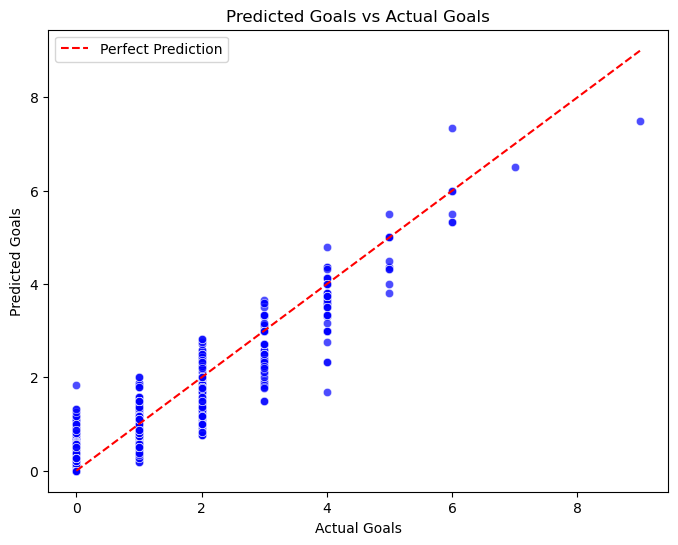

In [173]:
# Plot actual vs predicted goals
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['goals'], y=df['predicted_goals'], alpha=0.7, color='blue')

# Add a diagonal reference line (perfect prediction line)
plt.plot([df['goals'].min(), df['goals'].max()], 
         [df['goals'].min(), df['goals'].max()], 
         linestyle='--', color='red', label="Perfect Prediction")

# Labels and title
plt.xlabel("Actual Goals")
plt.ylabel("Predicted Goals")
plt.title("Predicted Goals vs Actual Goals")
plt.legend()
plt.show()

The plot for the whole dataset show the sparse nature of the data which is hard to to fitted along the dashed line. Since we are not able to properly visualize the points using the whole dataset, we will plot separate graphs for all 20 Premier League teams in the dataset. The results are shown below:

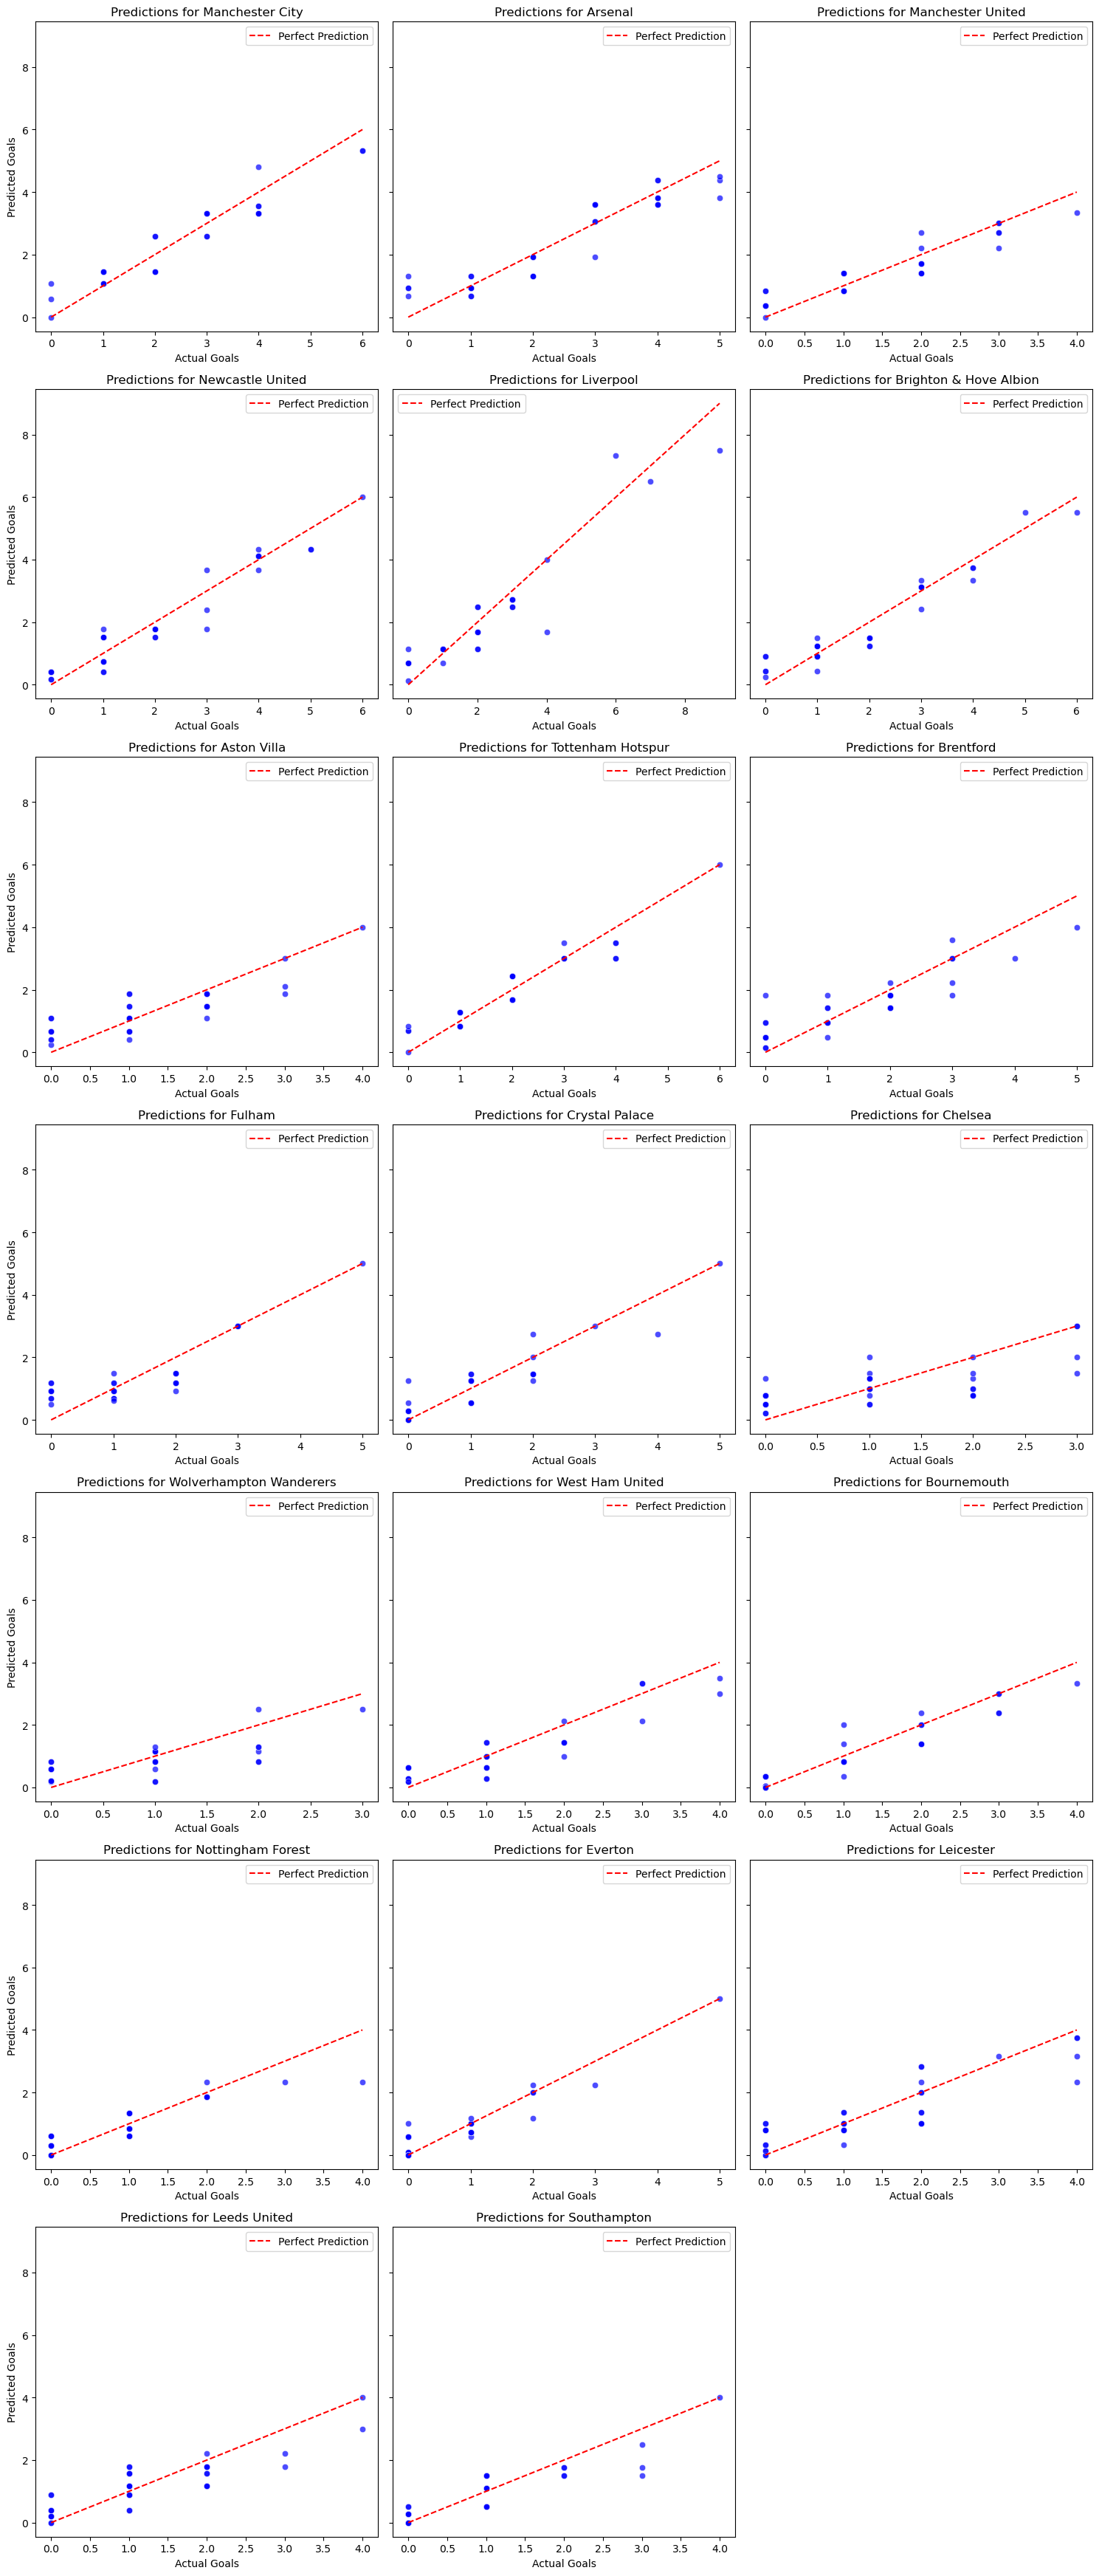

In [176]:
# Get unique teams
teams = df['team_name'].unique()
num_teams = len(teams)

# Define grid size (3 columns per row)
cols = 3
rows = int(np.ceil(num_teams / cols))  # Calculate required rows

# Create subplots
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(5 * cols, 5 * rows), sharey=True)

# Flatten the axes array for easy iteration (handles cases where rows * cols > num_teams)
axes = axes.flatten()

for i, team in enumerate(teams):
    team_data = df[df['team_name'] == team]

    # Scatter plot for each team
    sns.scatterplot(x=team_data['goals'], y=team_data['predicted_goals'], alpha=0.7, ax=axes[i], color='blue')
    
    # Perfect prediction line
    min_goal, max_goal = team_data['goals'].min(), team_data['goals'].max()
    axes[i].plot([min_goal, max_goal], [min_goal, max_goal], linestyle='--', color='red', label="Perfect Prediction")

    # Labels
    axes[i].set_xlabel("Actual Goals")
    axes[i].set_ylabel("Predicted Goals")
    axes[i].set_title(f"Predictions for {team}")
    axes[i].legend()

# Hide unused subplots (if teams don't fill all slots)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

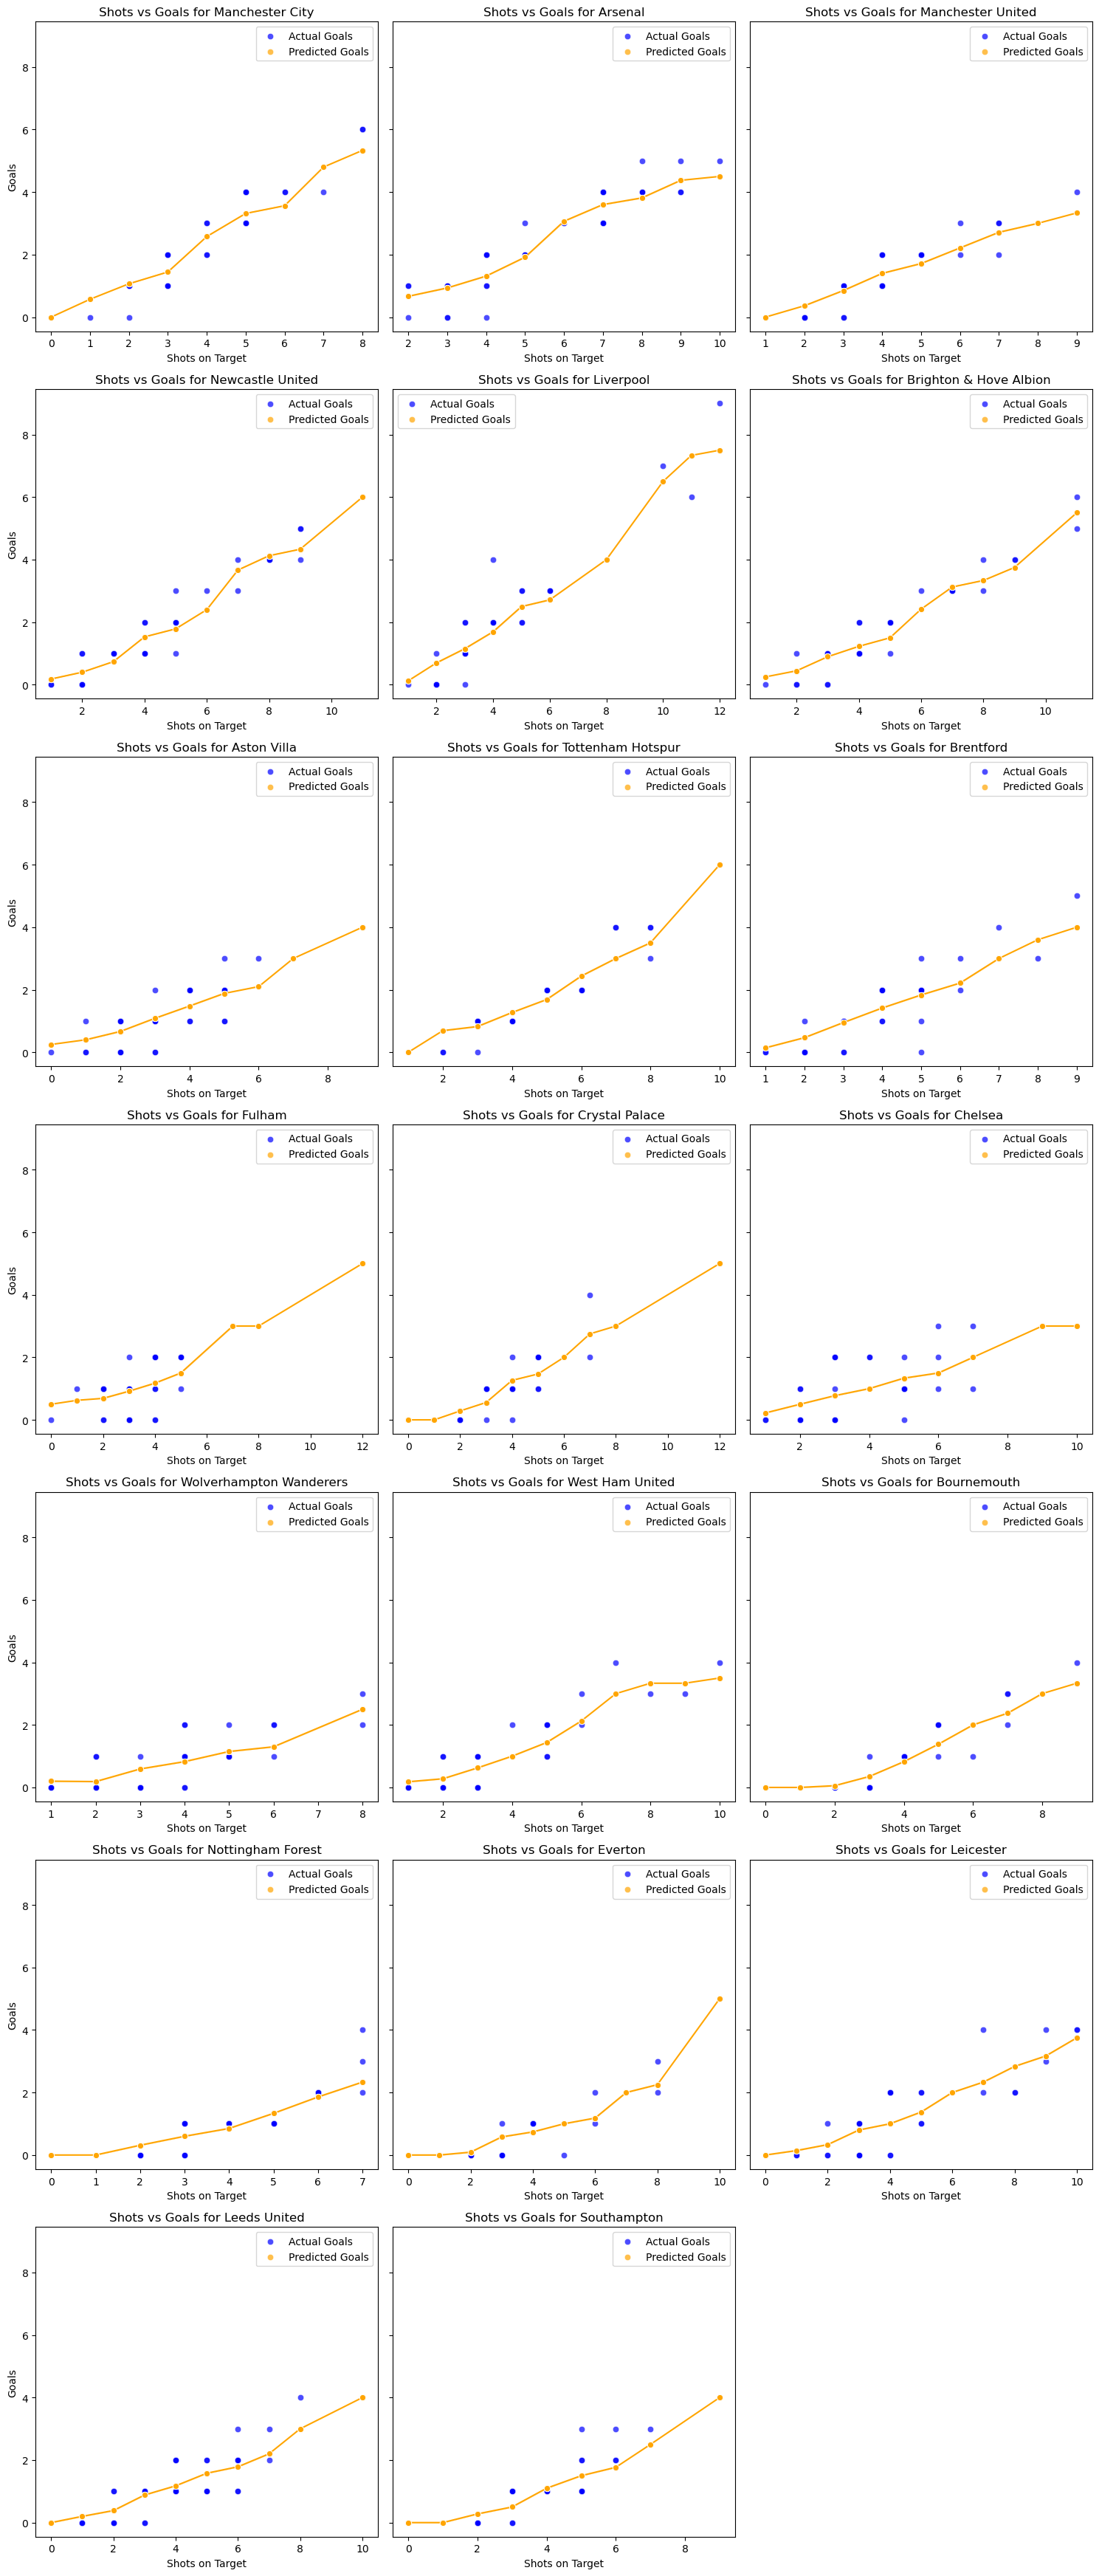

In [178]:
# Get unique teams
teams = df['team_name'].unique()
num_teams = len(teams)

# Define grid size (3 columns per row)
cols = 3
rows = int(np.ceil(num_teams / cols))  # Calculate required rows

# Create subplots
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(5 * cols, 5 * rows), sharey=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, team in enumerate(teams):
    team_data = df[df['team_name'] == team]

    # Scatter plot for actual goals
    sns.scatterplot(x=team_data['shots_on_target'], y=team_data['goals'], alpha=0.7, ax=axes[i], color='blue', label="Actual Goals")

    # Scatter plot for predicted goals
    sns.scatterplot(x=team_data['shots_on_target'], y=team_data['predicted_goals'], alpha=0.7, ax=axes[i], color='orange', label="Predicted Goals")
    sns.lineplot(x=team_data['shots_on_target'], y=team_data['predicted_goals'], ax=axes[i], color='orange', linestyle='-', marker='o')


    # Labels
    axes[i].set_xlabel("Shots on Target")
    axes[i].set_ylabel("Goals")
    axes[i].set_title(f"Shots vs Goals for {team}")
    axes[i].legend()

# Hide unused subplots (if teams don't fill all slots)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Takeaways

From this algorithm, we found out that two important features to predict the number of goals are the shots on target and team name. For this particular season, teams like Manchester City, Liverpool, and Arsenal had the highest shot accuracy rate. These teams had higher chances of scoring a goal for every shot on target.
On the other hand, teams like Everton and Wolverhanpton Wanderers had the lowest shot accuracy in the league. Their lack of finishing resulted in a low number of goals scored, despite having the same number of shots as other teams.

A custom calcualtion algorithm was used to predict the number of goals scored for every team. This is due to the different shot accuracy rates of the teams in the league, as explored earlier. The algorithm had a strong prediction ability of over 84%, indicating good performance across all teams.

Newcastle United and Brighton & Hove Albion were the teams with the highest R-squared score, where their number of goals could be predicted easily due to consistent performances.

Chelsea and Wolverhampton Wanderers had the lowest R-squared values, signalling less accurate predictions. This variation exists because of the random nature of football. There will be instances when a team can overform or underperform.